In [1]:
# sys, file and nav packages:
import os
import datetime as dt
import csv
import json

# math packages:
import pandas as pd
import numpy as np
import math

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# home brew utitilties
import utilities.utility_functions as ut
import utilities.abundance_classes as ac

# chart kwargs
title_k = {'loc':'left', 'pad':14, 'linespacing':1.5, 'fontsize':12}
title_k14 = {'loc':'left', 'pad':16, 'linespacing':1.5, 'fontsize':14}
xlab_k = {'labelpad':10, 'fontsize':12}
xlab_k14 = {'labelpad':14, 'fontsize':14}

survey_data, location_data, code_defs, stat_ent, geo_data, output = ut.make_local_paths()

In [2]:
# set some parameters:
start_date = '2020-04-01'
end_date ='2021-04-01'

# name the folder:
name_of_project = 'projectdescription'

# use this to store things:
project_directory = ut.make_project_folder(output, name_of_project)

# keep track of output
files_generated = []
figure_num = 0
data_num = 0

# kwargs for the abundance class
group_names_locations = {
    "waste water": "wastewater.json" ,
    "less than 5mm":"codeListMicros.json",
    "construction":"construction.json",
    "food":"foodstuff.json",
    "agg-con-trans":"cat.json",
    "agriculture":"ag.json",
    "tobacco":"tobac.json",
    "recreation":"recreation.json",    
    "packaging non food":"packaging.json",
    "personal items":"pi.json",    
}


frag_plas = {"fragmented plastics":["G79", "G78", "G75"]}

these_cols = ['loc_date', 'location', 'water_name','type', 'date']

foams={'G82':['G82', 'G912'], 'G81':['G81', 'G911'], 'G74':['G74', 'G910', 'G909']}

# convenience method to organize output
def add_output(**kwargs):
    files_generated.append({'tag':kwargs['tag'], 'number':kwargs['figure_num'], 'file':kwargs['file'],'type':kwargs['a_type']})
    if kwargs['a_type'] == 'data':
        kwargs['data'].to_csv(F"{kwargs['file']}.csv", index=False)
    else:
        plt.savefig(F"{kwargs['file']}.jpeg", dpi=300)
print(F"\nThis is the output directory for this notebook:\n\n   {project_directory}\n\nIt can be called by typing 'project_directory'\n")


This is the output directory for this notebook:

   output/projectdescription

It can be called by typing 'project_directory'



In [3]:
# non aggregated survey data
# Zero values are assigned for all codes not identified at a survey, for each survey
dfSurveys = pd.read_csv(F"{survey_data}/results_with_zeroes.csv")

# house keeping
dfSurveys = dfSurveys[(dfSurveys.date >= start_date)&(dfSurveys.date <= end_date)]
dfSurveys['date'] = pd.to_datetime(dfSurveys['date'], format="%Y-%m-%d")

# river bassin labels
river_bassins = ut.json_file_get(F"{location_data}/river_basins.json")

# beach data
dfBeaches = pd.read_csv(F"{location_data}/beaches_with_ranks.csv")
dfBeaches.set_index('slug', inplace=True)

# assign river bassin labels to locations:
for k,v in river_bassins.items():
    dfBeaches.loc[dfBeaches.water_name.isin(v), 'river_bassin'] = k

# code definitions
dfCodes = pd.read_csv(F"{code_defs}/mlw_codes.csv", index_col='code')

# dimensional data
dfDims = pd.read_csv(F"{survey_data}/dims_data.csv")

# project lakes and beaches:
project_lakes = ut.json_file_get(F"{location_data}/project_lakes.json")
project_beaches = ut.json_file_get(F"{location_data}/project_beaches.json")

In [4]:
# make a copy of the survey data and tag the records as either lake or river:
data = dfSurveys.copy()

# map lake or river from dfBeaches
lakes = dfBeaches[dfBeaches.water == 'l'].water_name.unique()
rivers = dfBeaches[dfBeaches.water == 'r'].water_name.unique()

# map values to new column t:
data['type'] = 't'
for a_place in data.water_name.unique():
    data.loc[data.water_name.isin(lakes), 'type'] = 'l'
    data.loc[data.water_name.isin(rivers), 'type'] = 'r'

# check if there any un categorized records:
if len(data[data['type']=='t']) > 0:
    print(F"\nThere are {len(data[data['type']=='t'])} records that were not classified as either lake or river:\n\n{data[data['type']=='t']}\n")
else:
    pass

## <span style="color:#008891">Description of survey results</span>

### <span style="color:#008891"> Total number of surveys and observations, total number of objects found, number of cities and total population concerned</span>

In [5]:
# put the data into a class
a_class_kwargs = dict(
    code_group_data=group_names_locations,
    new_code_group=frag_plas,
    levels=['river_bassin', 'water_name', 'city'],
    river_bassins=river_bassins,
    exp_variables=['population','buildings', 'streets', 'intersects', 'pop_group_proj', 'pop_group_rip', 'streets_rank', 'buildings_rank'],
    code_group_loc=output,
    these_cols=these_cols,
    foams=foams
)
a = ac.PreprocessData(data, dfBeaches,**a_class_kwargs)

In [6]:
# define the final data set here:
a_data = a.survey_data[a.survey_data.river_bassin != 'reuss'].copy()

# describe the data set:
num_obs = len(a_data)
num_samps = len(a_data.loc_date.unique())
num_obj = a_data.quantity.sum()
num_locs = len(a_data.location.unique())

# number of municipalities
a_map = dfBeaches['city']
munis = [a_map[x] for x in a_data.location.unique()]
munis = list(set(munis))
num_munis = len(munis)

# population
total_pop_d = dfBeaches.loc[a_data.location.unique()][['city', 'population']]
total_pop_c = total_pop_d.drop_duplicates('city')
total_pop = total_pop_c.population.sum()

In [7]:
print(F"There are {'{:,}'.format(num_obs)} observations from {num_samps} surveys.\n\nThere were {'{:,}'.format(num_obj)} objects collected from {num_locs} different locations")
print(F"\nThe survey concerns {num_munis} municipalities with a total population of ~{'{:,}'.format(total_pop)}")
print(F"\nThis data is valid for surveys surveys between {start_date} and {end_date}")
print(F"\nThe municpalities where the surveys were conducted:\n\n{munis}\n")

There are 76,024 observations from 344 surveys.

There were 50,197 objects collected from 120 different locations

The survey concerns 67 municipalities with a total population of ~1,575,802

This data is valid for surveys surveys between 2020-04-01 and 2021-04-01

The municpalities where the surveys were conducted:

['Cheyres-Châbles', 'Unterengstringen', 'Biel/Bienne', 'Estavayer', 'Lüscherz', 'Freienbach', 'Schmerikon', 'Küsnacht (ZH)', 'Brügg', 'Gambarogno', 'Bönigen', 'Neuchâtel', 'Brugg', 'Kallnach', 'Riddes', 'Locarno', 'Yverdon-les-Bains', 'Leuk', 'Bern', 'Port', 'Brienz (BE)', 'Zürich', 'Lausanne', 'Saint-Gingolph', 'Thun', 'Allaman', 'Nidau', 'Gals', 'Walenstadt', 'Salgesch', 'Gland', 'Richterswil', 'Spiez', 'Köniz', 'Minusio', 'Montreux', 'Grandson', 'Walperswil', 'Sion', 'Le Landeron', 'Rapperswil-Jona', 'Quarten', 'Beatenberg', 'Tolochenaz', 'Ascona', 'Hauterive (NE)', 'Bellinzona', 'Boudry', 'Saint-Sulpice (VD)', 'Weesen', 'Solothurn', 'Gebenstorf', 'Genève', 'Versoix', '

### <span style="color:#008891">Total length, area, weight, weight of plastic objects and field time</span>

Dimensional data is kept for all surveys. This includes:

1. Length of survey area
2. Surface area
3. Weight of all objects
4. Weight of all plastics
5. Weight of all plastics < 5mm
6. Time to complete a survey

In [8]:
# gather the dimensional data for the time frame basin
som_dims = dfDims[dfDims.date <= end_date].copy()

# map the number of samples per water feature or bassin:
samples_feature = a_data.groupby('water_name').loc_date.nunique()
samples_bassin = a_data.groupby('river_bassin').loc_date.nunique()

# map total quantity per river bassin:
qty_bassin = a_data.groupby('river_bassin').quantity.sum()

# the loc date key needs updating:
som_dims['new_loc_date'] = list(zip(som_dims.location, som_dims.date))

# add travel and incidental time:
som_dims['total_time'] = som_dims.time_minutes+120
som_dims['total_time'] = som_dims.total_time/60
som_dims['total_time'] = som_dims.total_time.round(2)

# map locations to feature names
location_wname_key = dfBeaches[['water_name']]

# assign a water feature name to each record
som_dims['water_name'] = som_dims.location.map(lambda x: location_wname_key.loc[x][0])

# assign a river bassin name to each record
for k,v in river_bassins.items():
    som_dims.loc[som_dims.water_name.isin(v), 'river_bassin'] = k

# group by river bassin
dims_summary_stats = som_dims.groupby('river_bassin').agg({'total_time':'sum', 'length':'sum', 'area':'sum', 'total_w':'sum', 'mac_plast_w':'sum', 'loc_date':'nunique'})

# get the number of samples per river bassin
dims_summary_stats['n_samples'] = dims_summary_stats.index.map(lambda x: ut.use_this_key(x, samples_bassin, column='loc_date'))

# remove records that have no sample data
dims_summary_stats = dims_summary_stats[dims_summary_stats.n_samples != 'no data'].copy()

# convert the plastic weights to kilos
dims_summary_stats['mac_plast_w'] = dims_summary_stats.mac_plast_w/1000

# get the quantity found per river bassin
dims_summary_stats['quantity'] = dims_summary_stats.index.map(lambda x: ut.use_this_key(x, qty_bassin))

print(F"\nThe cumulative results: time in the field, meters surveyed, m² surveyed, the total weight removed, the total plastic weight, the number of samples and number of objects found:\n\n{dims_summary_stats.sum().round(2)}\n")

print(F"\nPer river basin: time in the field, meters surveyed, m² surveyed, the total weight removed, the total plastic weight, the number of samples and number of objects found\n\n")

dims_summary_stats[['total_time','quantity', 'length', 'area', 'total_w', 'mac_plast_w', 'n_samples']].round(2)


The cumulative results: time in the field, meters surveyed, m² surveyed, the total weight removed, the total plastic weight, the number of samples and number of objects found:

total_time      1365.02
length         17647.00
area           86562.35
total_w          986.34
mac_plast_w       84.11
loc_date         343.00
n_samples        344.00
quantity       50197.00
dtype: float64


Per river basin: time in the field, meters surveyed, m² surveyed, the total weight removed, the total plastic weight, the number of samples and number of objects found




,total_time,quantity,length,area,total_w,mac_plast_w,n_samples
river_bassin,,,,,,,
aare,530.80,12884,7476,34695.80,68.27,28.52,129
linth,381.15,8796,4980,24239.80,363.64,12.41,99
rhone,388.49,27087,4136,22638.25,520.66,41.35,99
ticino,64.58,1430,1055,4988.50,33.77,1.83,17


In [9]:
    
print(F"\nThese are the project beaches:\n\n{project_beaches}\n")
print(F"\nThese are the project lakes:\n\n{project_lakes}\n")


These are the project beaches:

['neuenburgersee_cudrefin_mattera', 'la-petite-plage', 'evole-plage', 'plage-de-cheyres', 'mullermatte', 'bielersee_vinelz_fankhausers', 'baby-plage-geneva', 'baye-de-montreux-g', 'grand-clos', 'preverenges', 'quai-maria-belgia', 'zurichsee_wollishofen_langendorfm', 'zurichsee_kusnachterhorn_thirkell-whitej', 'zuerichsee_richterswil_benkoem_2', 'rastplatz-stampf', 'weissenau-neuhaus', 'thunersee_spiez_meierd_1', 'walensee_walenstadt_wysse', 'gasi-strand', 'vira-gambarogno', 'sentiero-giro-del-golf-spiaggia', 'maladaire']


These are the project lakes:

['Bielersee', 'Walensee', 'Zurichsee', 'Lac Léman', 'Thunersee', 'Neuenburgersee', 'Lago Maggiore']



#### <span style="color:#008891">Identify dimensional data records that do not have a matching daily survey total or have an extreme weight value and identify survey dates that do not have a dims record:</span>

In [10]:
# map loc_date to quantity from all surveys        
some_q = a.daily_totals_all[['loc_date', 'quantity']].copy()
some_q.set_index('loc_date', inplace=True)

ldu = a_data.loc_date.unique()
ddu = som_dims.new_loc_date.unique()

# map quantity per survey to the dims data
som_dims['quantity'] = som_dims.new_loc_date.map(lambda x: ut.use_this_key(x,some_q, column='quantity'))
print(F"\nThese are the dims records that did not get tagged with a quantity:\n\n{som_dims[som_dims.quantity == 'no data'][['location', 'date', 'water_name']]}\n")
print(F"These are the surveys that do not have dimensional data:\n\n{[x for x in list(ldu) if x not in list(ddu)]}\n")


These are the dims records that did not get tagged with a quantity:

                                     location        date      water_name
111                  lacleman_gland_lecoanets  2020-11-27       Lac Léman
132                            luscherz-plage  2021-01-26       Bielersee
149                               mullermatte  2020-01-26       Bielersee
171                          plage-de-cheyres  2020-03-15  Neuenburgersee
228          schiffenensee_duedingen_hirschij  2020-07-11   Schiffenensee
244                                strandbeiz  2020-03-20       Zurichsee
251                  thunersee_spiez_meierd_1  2020-03-08       Thunersee
288                 walensee_walenstadt_wysse  2020-03-17        Walensee
331  zurichsee_kusnachterhorn_thirkell-whitej  2020-03-20       Zurichsee
332  zurichsee_kusnachterhorn_thirkell-whitej  2020-03-20       Zurichsee
344         zurichsee_wollishofen_langendorfm  2020-03-11       Zurichsee

These are the surveys that do not have di

In [11]:
print(F"\nThese are the dims records that have a weight greater than 50:\n\n{som_dims[som_dims.total_w > 50][['location', 'date', 'water_name', 'total_w']]}\n")


These are the dims records that have a weight greater than 50:

              location        date water_name  total_w
113  lavey-les-bains-2  2021-02-24      Rhône     80.0
137          maladaire  2020-07-29  Lac Léman    147.0
162           murg-bad  2020-10-23   Walensee    330.0
191        preverenges  2020-09-08  Lac Léman    230.0



#### <span style="color:#008891">The time to complete a survey versus the number of objects found</span>

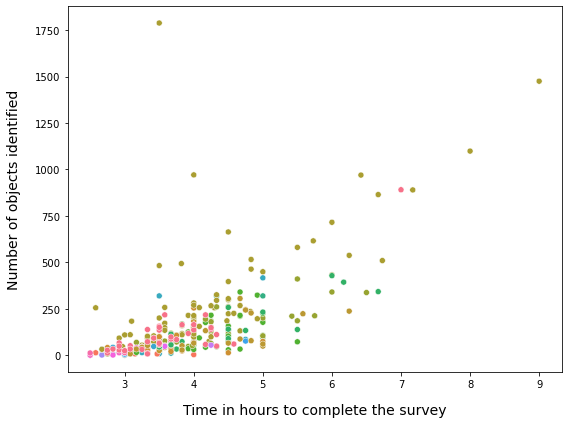

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=som_dims[som_dims.quantity != 'no data'], x='total_time', y='quantity', hue='water_name', palette='husl', ax=ax)
ax.get_legend().remove()
ax.set_xlabel("Time in hours to complete the survey", **xlab_k14 )
ax.set_ylabel("Number of objects identified", **xlab_k14)
plt.tight_layout()
plt.show()

#### Hopefully that just worked for you

if not contact analyst@hammerdirt.ch